In [ ]:
# Develop RNN model for cryptocurrency pricing prediction or text sentiment analysis

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import pandas as pd

In [2]:
import yfinance as yf

# Download Bitcoin data (BTC-USD)
df = yf.download('BTC-USD', start='2017-01-01', end='2024-12-31')

# Save the data to a CSV file
df.to_csv('BTC-USD.csv')

# Print the first few rows to verify
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                         BTC-USD      BTC-USD      BTC-USD      BTC-USD   
Date                                                                            
2017-01-01 00:00:00+00:00   998.325012   998.325012  1003.080017   958.698975   
2017-01-02 00:00:00+00:00  1021.750000  1021.750000  1031.390015   996.702026   
2017-01-03 00:00:00+00:00  1043.839966  1043.839966  1044.079956  1021.599976   
2017-01-04 00:00:00+00:00  1154.729980  1154.729980  1159.420044  1044.400024   
2017-01-05 00:00:00+00:00  1013.380005  1013.380005  1191.099976   910.416992   

Price                             Open     Volume  
Ticker                         BTC-USD    BTC-USD  
Date                                               
2017-01-01 00:00:00+00:00   963.658020  147775008  
2017-01-02 00:00:00+00:00   998.617004  222184992  
2017-01-03 00:00:00+00:00  1021.599976  185168000  
2017-01-04 00:00:00+00:00  1044.400024 

In [3]:
# Visualization settings
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [4]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
# Scale the data
scaler = MinMaxScaler()
close_price = df['Close'].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

SEQ_LEN = 100

In [6]:
# Function to create sequences of data
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

# Preprocess the data and split into training and testing sets
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split=0.85)

In [8]:
# Build the LSTM model
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

In [9]:
model = Sequential()
model.add(LSTM(input_shape=(WINDOW_SIZE, X_train.shape[-1]), units=200))
model.add(Dropout(rate=DROPOUT))
model.add(Dense(units=100))
model.add(Dense(1, activation="linear"))  # Changed to 'linear' for regression tasks

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [11]:
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=1, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)

67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0028 - val_loss: 3.1898e-04


In [12]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0043
Test loss: 0.0078104278072714806


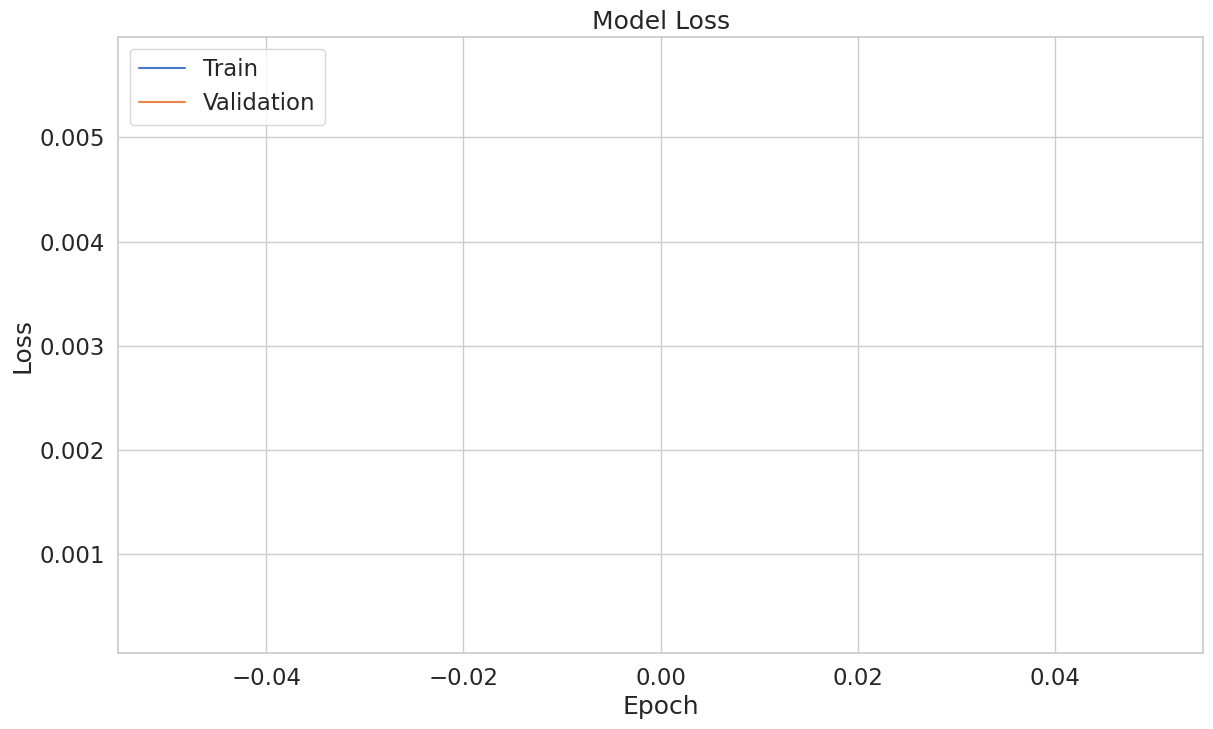

In [13]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Predicting the next value
def predict_next(data, seq_len):
    data_scaled = scaler.transform(data[-seq_len:])
    data_scaled = np.reshape(data_scaled, (1, seq_len, 1))  # Reshape for LSTM input
    prediction = model.predict(data_scaled)
    prediction = scaler.inverse_transform(prediction)  # Inverse scaling
    return prediction

In [15]:
# Test the prediction function with the last sequence of data
last_sequence = close_price[-SEQ_LEN:]  # Take the last sequence from the dataset
predicted_price = predict_next(last_sequence, SEQ_LEN)
print(f"Predicted next price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted next price: 76609.296875


In [16]:
y_hat = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [17]:
# Inverse transform the predicted and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

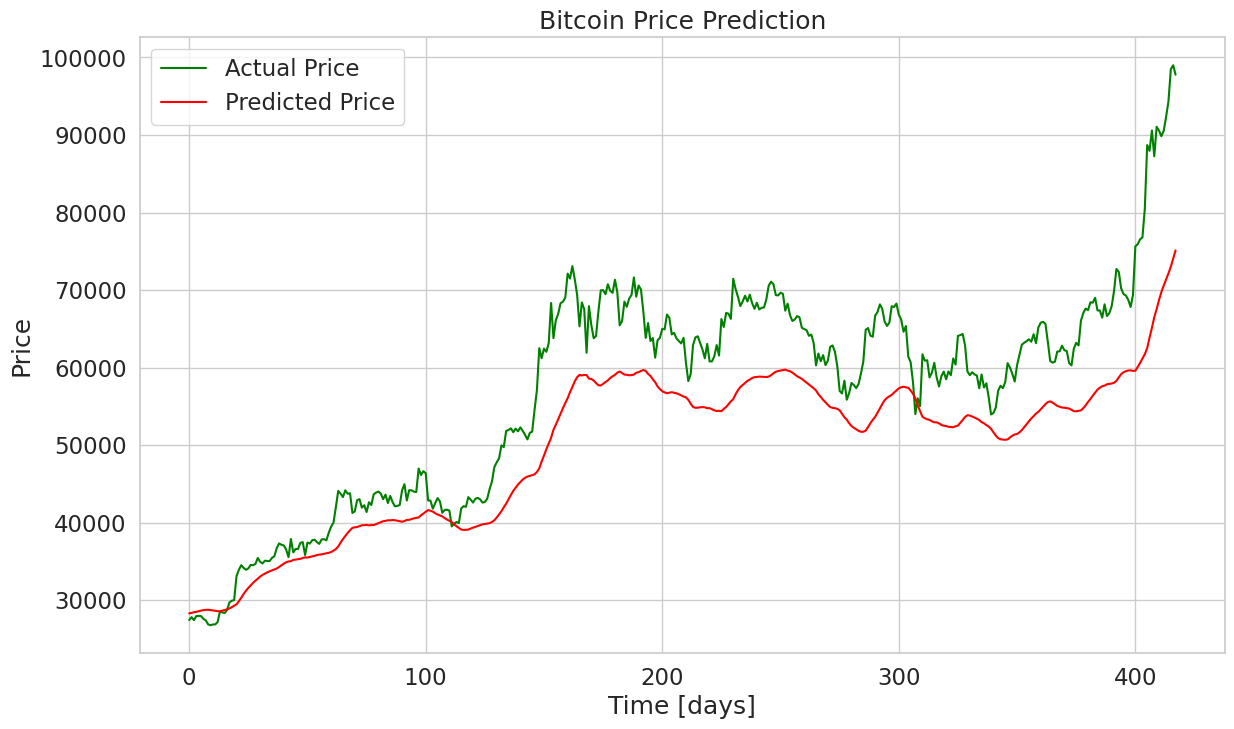

In [18]:
# Plot actual vs predicted prices
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()